In [1]:
# ============================================================
# Imports and global configuration
# ============================================================

import numpy as np
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

from skimage import io, color
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning

# ------------------------------------------------------------
# Warning handling (documented & intentional)
# ------------------------------------------------------------
# - UndefinedMetricWarning occurs when a class has no predicted samples.
#   This is explicitly handled using zero_division=0 in classification_report.
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

DATASET_DIR = Path(".")
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)


In [2]:
# Data handling and label encoding

def find_images(dirpath):
    """
    Recursively find all image files in a directory.

    Parameters
    ----------
    dirpath : Path or str
        Root directory of the dataset.

    Returns
    -------
    list of Path
        Sorted list of image file paths.
    """
    exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    return sorted(p for p in Path(dirpath).rglob("*") if p.suffix.lower() in exts)


def get_class(imgpath):
    """
    Infer class label from parent folder name.

    Assumes directory structure:
        root / class_name / image_file

    Parameters
    ----------
    imgpath : Path

    Returns
    -------
    str or None
        Class name or None if invalid.
    """
    if len(imgpath.parts) < 2:
        return None

    cls = imgpath.parts[-2]
    if cls.startswith("."):
        return None

    return cls


def get_numeric_labels(image_paths):
    """
    Convert string class labels to numeric labels.

    Parameters
    ----------
    image_paths : list of Path

    Returns
    -------
    y : ndarray
        Numeric class labels.
    label_encoder : LabelEncoder
        Encoder mapping class names to integers.
    valid_paths : ndarray
        Image paths with valid labels.
    """
    classes, valid_paths = [], []

    for p in image_paths:
        cls = get_class(p)
        if cls is not None:
            classes.append(cls)
            valid_paths.append(p)

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(classes)

    return y, le, np.array(valid_paths)


In [3]:
# Load datset and filter classes

paths = find_images(DATASET_DIR)
print(f"Found {len(paths)} images")

y, label_encoder, paths = get_numeric_labels(paths)
print("Classes:", label_encoder.classes_)
print("Samples per class:", np.bincount(y))

# Remove classes with fewer than 2 samples (required for stratified split)
counts = np.bincount(y)
valid_classes = np.where(counts >= 2)[0]

mask = np.isin(y, valid_classes)
paths = paths[mask]
y = y[mask]

print("Remaining classes:", label_encoder.classes_[valid_classes])
print("Samples per class:", np.bincount(y))


Found 5004 images
Classes: ['01_TUMOR' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '08_EMPTY' 'figures']
Samples per class: [625 625 625 625 625 625 625 625   3]
Remaining classes: ['01_TUMOR' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '08_EMPTY' 'figures']
Samples per class: [625 625 625 625 625 625 625 625   3]


In [4]:
# HLBP Descriptor

def hlbp(img, R=1, P=8, m=0.05, step=3):
    """
    Compute Histogram Local Binary Pattern (HLBP).

    NOTE
    ----
    Explicit loops are intentionally used for clarity and educational purposes.
    A vectorized implementation would be preferable for large-scale deployment.

    Parameters
    ----------
    img : ndarray
        Grayscale image.
    R : int
        Radius.
    P : int
        Number of neighbors.
    m : float
        Similarity threshold.
    step : int
        Sampling step size.

    Returns
    -------
    h : ndarray
        Normalized HLBP histogram.
    """
    img = img.astype(np.float32)
    rows, cols = img.shape
    h = np.zeros(2**P, dtype=np.float32)

    angles = np.linspace(0, 2*np.pi, P, endpoint=False)
    coords = [(R*np.sin(a), R*np.cos(a)) for a in angles]

    for i in range(R, rows - R, step):
        for j in range(R, cols - R, step):
            gc = img[i, j]
            code = 0
            for bit, (dy, dx) in enumerate(coords):
                y_n = int(round(i + dy))
                x_n = int(round(j + dx))
                if abs(img[y_n, x_n] - gc) <= m:
                    code |= (1 << bit)
            h[code] += 1

    if h.sum() > 0:
        h /= h.sum()

    return h


In [5]:
# Multiscale Feature Extraction

def extract_multiscale_hlbp(img, m=0.05):
    """
    Extract multi-scale HLBP features from a grayscale image.

    Returns
    -------
    ndarray
        Concatenated HLBP histograms (R=1,2,3).
    """
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[..., :3]

    img = np.clip(img.astype(np.float32) / 255.0, 1e-6, 1.0)
    gray = color.rgb2gray(img)

    return np.hstack([
        hlbp(gray, R=1, m=m),
        hlbp(gray, R=2, m=m),
        hlbp(gray, R=3, m=m)
    ])


def colour_multiscale_hlbp(img, m=0.05):
    """
    Extract multi-scale HLBP features from LAB colour channels.

    Returns
    -------
    ndarray
        Concatenated HLBP histograms from L, a, b channels.
    """
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[..., :3]

    img = np.clip(img.astype(np.float32) / 255.0, 1e-6, 1.0)
    lab = color.rgb2lab(img)

    feats = []
    for c in range(3):
        feats.extend([
            hlbp(lab[:, :, c], R=1, m=m),
            hlbp(lab[:, :, c], R=2, m=m),
            hlbp(lab[:, :, c], R=3, m=m)
        ])

    return np.hstack(feats)


In [6]:
# Experiment Runner (KNN)

def extract_features(image_paths, use_colour=False, m=0.05):
    """
    Extract feature vectors for all images.
    """
    X = []
    for p in image_paths:
        img = io.imread(p)
        if use_colour:
            X.append(colour_multiscale_hlbp(img, m=m))
        else:
            X.append(extract_multiscale_hlbp(img, m=m))
    return np.array(X)


def run_experiment(
    image_paths,
    y,
    use_colour=False,
    m=0.05,
    k=3,
    stratify_split=True
):
    """
    Run a classification experiment using HLBP features and KNN.

    Parameters
    ----------
    image_paths : array-like
        Paths to input images.
    y : array-like
        Numeric class labels.
    use_colour : bool
        Whether to use colour HLBP (LAB space).
    m : float
        HLBP tolerance parameter.
    k : int
        Number of neighbors for KNN.
    stratify_split : bool
        Enable stratified train/test split if possible.
    """

    print("\n==============================")
    print("Colour features:", use_colour)
    print("m =", m)
    print("k =", k)
    print("==============================")

    X = extract_features(image_paths, use_colour=use_colour, m=m)

    stratify_arg = y if stratify_split and np.min(np.bincount(y)) >= 2 else None
    if stratify_arg is None and stratify_split:
        print("Stratification disabled (insufficient samples per class)")

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=stratify_arg
    )

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)

    print("Accuracy:", accuracy_score(yte, ypred))
    print("Confusion matrix:\n", confusion_matrix(yte, ypred))
    print("Classification report:\n",
          classification_report(yte, ypred, zero_division=0))

    return accuracy_score(yte, ypred)



In [7]:
# ==============================
# Basic 3x3 LBP and HLBP
# ==============================

def lbp_3x3(img):
    img = img.astype(np.float32)
    rows, cols = img.shape
    coded = np.zeros_like(img)
    hist = np.zeros(256)

    weights = np.array([
        [128, 64, 32],
        [1,   0, 16],
        [2,   4,  8]
    ])

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            patch = img[i-1:i+2, j-1:j+2]
            code = np.sum((patch >= img[i, j]) * weights)
            coded[i, j] = code
            hist[int(code)] += 1

    if hist.sum() > 0:
        hist /= hist.sum()

    return coded, hist


def hlbp_3x3(img, m=0.05):
    img = img.astype(np.float32)
    rows, cols = img.shape
    coded = np.zeros_like(img)
    hist = np.zeros(256)

    weights = np.array([
        [128, 64, 32],
        [1,   0, 16],
        [2,   4,  8]
    ])

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            patch = img[i-1:i+2, j-1:j+2]
            code = np.sum((np.abs(patch - img[i, j]) <= m) * weights)
            coded[i, j] = code
            hist[int(code)] += 1

    if hist.sum() > 0:
        hist /= hist.sum()

    return coded, hist


In [8]:
# LBP vs HLBP Visualization

def visualize_lbp_hlbp(image_path, save_path, dpi=300):
    """
    Visualize and compare LBP and HLBP representations.
    """
    img = io.imread(image_path)
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[..., :3]

    img = img.astype(np.float32) / 255.0
    gray = color.rgb2gray(img)

    lbp_img, lbp_hist = lbp_3x3(gray)
    hlbp_img, hlbp_hist = hlbp_3x3(gray, m=0.05)

    def normalize(x):
        p1, p99 = np.percentile(x, (1, 99))
        x = np.clip(x, p1, p99)
        return (x - x.min()) / (x.max() - x.min() + 1e-8)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(gray, cmap="gray")
    axes[0, 1].set_title("Grayscale")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(normalize(lbp_img), cmap="inferno")
    axes[0, 2].set_title("LBP")

    axes[1, 0].imshow(normalize(hlbp_img), cmap="inferno")
    axes[1, 0].set_title("HLBP")

    axes[1, 1].plot(lbp_hist, label="LBP")
    axes[1, 1].plot(hlbp_hist, label="HLBP")
    axes[1, 1].legend()

    axes[1, 2].hist(
        [lbp_img.ravel(), hlbp_img.ravel()],
        bins=50, label=["LBP", "HLBP"], alpha=0.7
    )
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()


In [9]:
# ==============================
# Dataset sanity check
# ==============================

print("Number of images:", len(paths))
print("Number of labels:", len(y))
print("Classes:", label_encoder.classes_)
print("Samples per class:", np.bincount(y))


Number of images: 5003
Number of labels: 5003
Classes: ['01_TUMOR' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '08_EMPTY' 'figures']
Samples per class: [625 625 625 625 625 625 625 625   3]


In [10]:
# ==============================
# Reproducible train/test split
# ==============================

paths_train, paths_test, y_train, y_test = train_test_split(
    paths,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train images:", len(paths_train))
print("Test images:", len(paths_test))


Train images: 3502
Test images: 1501


In [11]:
# ==============================
# Experiment 1: Grayscale HLBP
# ==============================

acc_gray = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=False,
    m=0.05,
    k=3
)



Colour features: False
m = 0.05
k = 3


/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Accuracy: 0.6622251832111925
Confusion matrix:
 [[126   5  11  10  12  19   4   0   0]
 [ 23 110  31   8   9   6   0   0   0]
 [ 42  12  85  18   8  23   0   0   0]
 [ 11  10  17 147   0   3   0   0   0]
 [ 38  22  32  10  63  22   1   0   0]
 [ 27   6  29  15   4 106   0   0   0]
 [  6   1   0   0   1   0 173   7   0]
 [  0   0   0   0   0   0   4 183   0]
 [  0   0   0   0   0   0   0   0   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      0.67      0.55       187
           1       0.66      0.59      0.62       187
           2       0.41      0.45      0.43       188
           3       0.71      0.78      0.74       188
           4       0.65      0.34      0.44       188
           5       0.59      0.57      0.58       187
           6       0.95      0.92      0.94       188
           7       0.96      0.98      0.97       187
           8       1.00      1.00      1.00         1

    accuracy                      

In [12]:
# ==============================
# Experiment 2: Color HLBP (Lab)
# ==============================

acc_colour = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=True,
    m=0.05,
    k=3
)



Colour features: True
m = 0.05
k = 3


/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: divide by zero encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: overflow encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:857: RuntimeWarning: invalid value encountered in matmul
  return arr @ xyz_from_rgb.T.astype(arr.dtype)


Accuracy: 0.7188540972684877
Confusion matrix:
 [[135   9   6   8   7  22   0   0   0]
 [ 23  98  27   8  15  16   0   0   0]
 [ 21  32  93  15   6  21   0   0   0]
 [ 16   4   9 152   1   6   0   0   0]
 [ 29  12  15   3 110  18   1   0   0]
 [ 29   9   8   3   3 135   0   0   0]
 [  0   0   0   0   3   0 177   8   0]
 [  0   0   0   0   0   0   9 178   0]
 [  0   0   0   0   0   0   0   0   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.72      0.61       187
           1       0.60      0.52      0.56       187
           2       0.59      0.49      0.54       188
           3       0.80      0.81      0.81       188
           4       0.76      0.59      0.66       188
           5       0.62      0.72      0.67       187
           6       0.95      0.94      0.94       188
           7       0.96      0.95      0.95       187
           8       1.00      1.00      1.00         1

    accuracy                      

In [13]:
# =========================================
# Experiment 3: Effect of HLBP tolerance(m)
# =========================================

acc_m_low = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=False,
    m=0.02,
    k=3
)

acc_m_high = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=False,
    m=0.10,
    k=3
)



Colour features: False
m = 0.02
k = 3


/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Accuracy: 0.6255829447035309
Confusion matrix:
 [[130   1  19   9  12  12   4   0   0]
 [ 25 104  30  12   8   8   0   0   0]
 [ 52  23  69  15   6  23   0   0   0]
 [ 16  12  17 135   0   8   0   0   0]
 [ 49  17  34  13  53  21   1   0   0]
 [ 32   6  31  18  12  88   0   0   0]
 [  2   0   0   0   3   0 176   7   0]
 [  0   0   0   0   0   0   4 183   0]
 [  0   0   0   0   0   0   0   0   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.42      0.70      0.53       187
           1       0.64      0.56      0.59       187
           2       0.34      0.37      0.36       188
           3       0.67      0.72      0.69       188
           4       0.56      0.28      0.38       188
           5       0.55      0.47      0.51       187
           6       0.95      0.94      0.94       188
           7       0.96      0.98      0.97       187
           8       1.00      1.00      1.00         1

    accuracy                      

/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Accuracy: 0.6002664890073285
Confusion matrix:
 [[120   5  14   8  13  18   9   0   0]
 [ 28 100  25  10  11   7   6   0   0]
 [ 39  25  72  13   5  34   0   0   0]
 [ 15  14  10 135   3  11   0   0   0]
 [ 47  23  33  17  44  23   0   1   0]
 [ 29  10  36  19  11  82   0   0   0]
 [ 11   1   0   0   1   0 164  11   0]
 [  0   0   0   0   0   0   4 183   0]
 [  0   0   0   0   0   0   0   0   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.42      0.64      0.50       187
           1       0.56      0.53      0.55       187
           2       0.38      0.38      0.38       188
           3       0.67      0.72      0.69       188
           4       0.50      0.23      0.32       188
           5       0.47      0.44      0.45       187
           6       0.90      0.87      0.88       188
           7       0.94      0.98      0.96       187
           8       1.00      1.00      1.00         1

    accuracy                      

In [14]:
#=================================
# Experiment 4: Effect of K in KNN
#=================================

acc_k1 = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=False,
    m=0.05,
    k=1
)

acc_k5 = run_experiment(
    image_paths=paths,
    y=y,
    use_colour=False,
    m=0.05,
    k=5
)



Colour features: False
m = 0.05
k = 1


/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Accuracy: 0.6442371752165224
Confusion matrix:
 [[100   7  17  11  24  24   4   0   0]
 [ 15 107  31   9  12  13   0   0   0]
 [ 27  19  79  17  17  29   0   0   0]
 [  6  12  11 146   3  10   0   0   0]
 [ 30  16  23  16  74  27   1   1   0]
 [ 17   9  20  17  18 106   0   0   0]
 [  4   1   0   0   2   0 174   7   0]
 [  0   0   0   0   0   0   7 180   0]
 [  0   0   0   0   0   0   0   0   1]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.53      0.52       187
           1       0.63      0.57      0.60       187
           2       0.44      0.42      0.43       188
           3       0.68      0.78      0.72       188
           4       0.49      0.39      0.44       188
           5       0.51      0.57      0.54       187
           6       0.94      0.93      0.93       188
           7       0.96      0.96      0.96       187
           8       1.00      1.00      1.00         1

    accuracy                      

/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/gurjindersingh/env/lib/python3.9/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


Accuracy: 0.6708860759493671
Confusion matrix:
 [[121   1  17   9   9  24   6   0   0]
 [ 24 109  29   9   9   7   0   0   0]
 [ 39   9  92  17   8  23   0   0   0]
 [  8  11  11 151   3   4   0   0   0]
 [ 37  11  38  10  63  28   1   0   0]
 [ 18   2  26  22   6 113   0   0   0]
 [  4   0   0   0   2   0 175   7   0]
 [  0   0   0   0   0   0   4 183   0]
 [  0   0   0   0   0   0   1   0   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.48      0.65      0.55       187
           1       0.76      0.58      0.66       187
           2       0.43      0.49      0.46       188
           3       0.69      0.80      0.74       188
           4       0.63      0.34      0.44       188
           5       0.57      0.60      0.59       187
           6       0.94      0.93      0.93       188
           7       0.96      0.98      0.97       187
           8       0.00      0.00      0.00         1

    accuracy                      

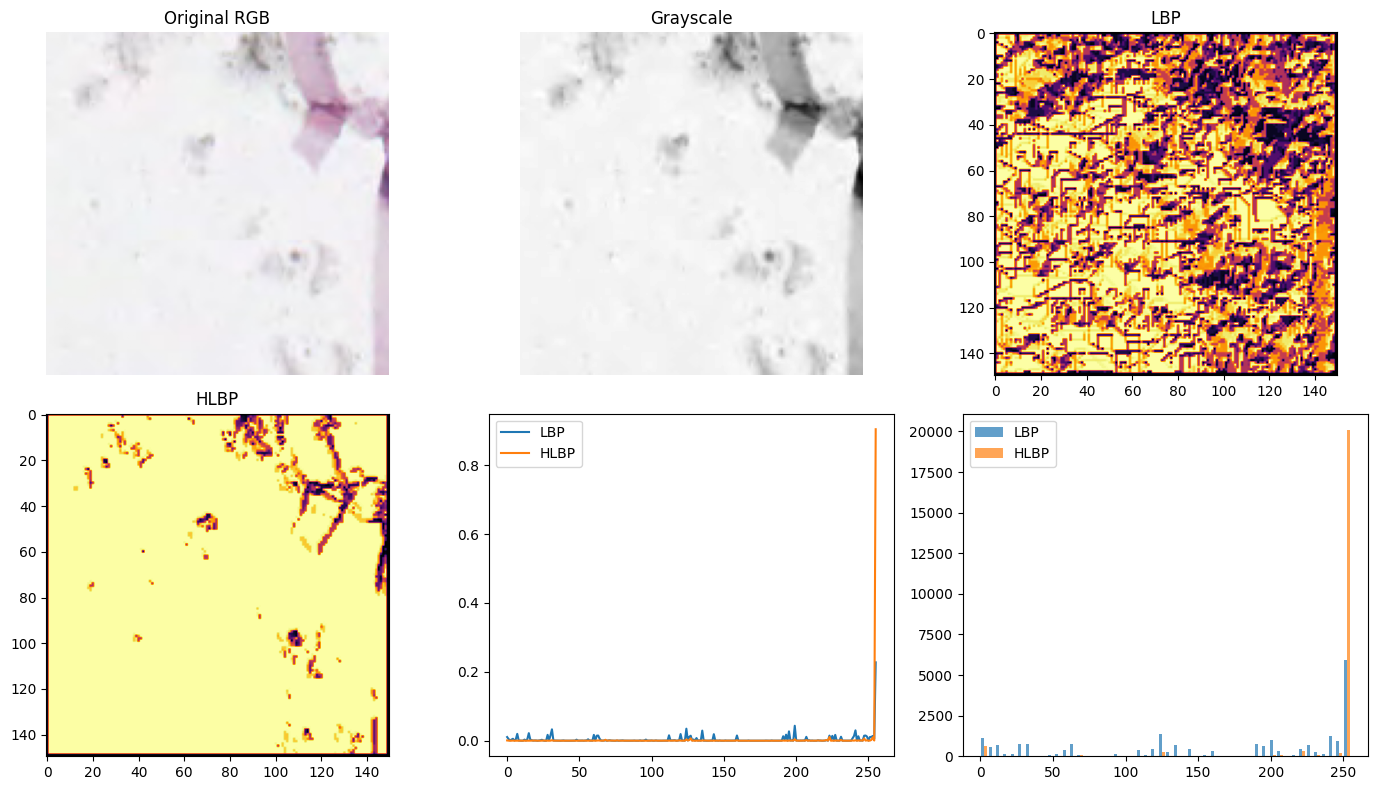

In [15]:
#==============================
# Visualization
#==============================

import os
os.makedirs("figures", exist_ok=True)

visualize_lbp_hlbp(
    paths_test[0],   # representative test image
    save_path="figures/hlbp_visualization_report.png"
)

